This tutorial demonstrates some convolutions and fits a simple convnet. Everything (the network, 
optimization, etc.) is done using Numbat only.

In [6]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
import numbat as nb
import numpy as onp

# Load CIFAR-10 dataset from OpenML
cifar10 = fetch_openml(data_id=40927, as_frame=False, parser='liac-arff')

In [7]:
batch, height, width, color = nb.axes()
data = jnp.reshape(cifar10["data"],[60000,3,32,32])/255.0
data = jnp.transpose(data,[0,2,3,1])
x = nb.ntensor(data,batch, height, width, color)
y = nb.ntensor(cifar10["target"].astype(int), batch)

In [9]:
print(f"{x.shape=}")
print(f"{y.shape=}")
num_classes = int(nb.max(y+1).numpy())
print(f"{num_classes=}")

x.shape=ShapeDict(batch=60000, height=32, width=32, color=3)
y.shape=ShapeDict(batch=60000)
num_classes=10


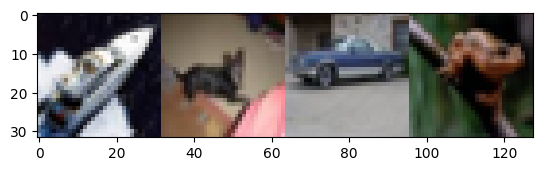

In [11]:
def display(x):
    y = nb.select(x, batch=batch[::15000])    
    z = y.numpy(height,batch,width,color)
    z = z.reshape(z.shape[0], z.shape[1]*z.shape[2], z.shape[3])
    plt.imshow(z)
display(x)

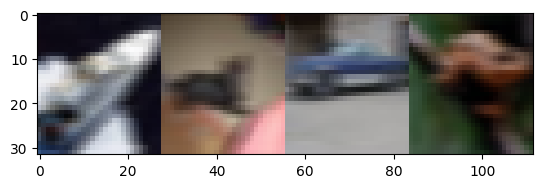

In [16]:
# blur across width
kern = nb.ntensor([0.2]*5, width)
z = nb.convolve(x, kern, axes={'width'}, mode='valid')
display(z)

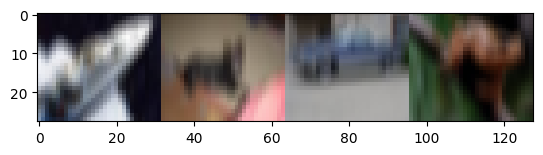

In [18]:
# blur across height
kern = nb.ntensor([0.2]*5, height)
z = nb.convolve(x, kern, axes={'height'}, mode='valid')
display(z)

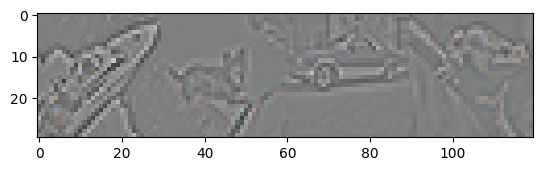

In [19]:
# 2d convolution
kern = nb.ntensor([[0,-1, 0],[-1,4,-1],[0,-1,0]], width, height)
z = nb.convolve(x, kern, axes={'width','height'}, mode='valid')
display(z/4+0.5)

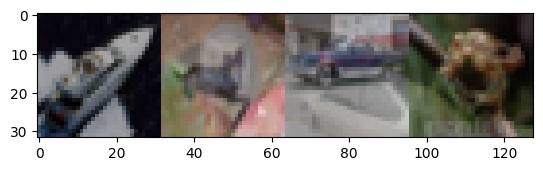

In [20]:
# blur across BATCH
kern = nb.ntensor([0.66, 0.34], batch)
z = nb.convolve(x, kern, axes={'batch'}, mode='same')
display(z)

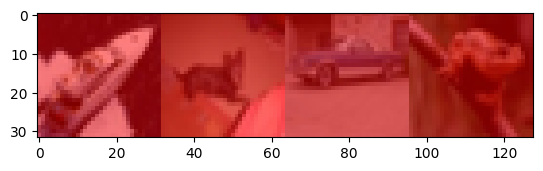

In [21]:
# change colors
red = nb.ntensor([1,0,0], color)
z = .5*x + .5*red
display(z)

In [22]:
def logistic(yi, scores):
    return nb.logsumexp(scores) - scores(category=yi)

def loss(y, scores):
    return nb.mean(nb.vmap(logistic,{batch})(y, scores))

def map(fun, *args):
    return jax.tree.map(fun, *args, is_leaf=nb.is_ntensor)

def signed_gradient(net, params, niter, stepsize):
    import time
    def fun(*params, key=None):
        minibatch = jax.random.randint(key, (1000,), 0, y.shape[batch])
        x_batch = x(batch=minibatch)
        y_batch = y(batch=minibatch)
        
        scores = net(x_batch, *params)
        print(f"{scores.shape=}")
        return loss(y_batch, scores)    
    
    gfun = nb.value_and_grad(fun, argnums=range(len(params)))

    @jax.jit
    def next(key, params, avg_g):
        key, subkey = jax.random.split(key)
        value, g = gfun(*params, key=subkey)
        avg_g = map(lambda avg_g_i, g_i: avg_g_i*0.9 + g_i*0.1, avg_g, g)
        params = map(lambda p_i, avg_g_i: p_i - stepsize*nb.sign(avg_g_i), params, avg_g)
        return key, params, avg_g, value
    
    avg_g = map(lambda p_i: 0*p_i, params)

    key = jax.random.PRNGKey(0)

    t0 = time.time()
    for i in range(niter):
        key, params, avg_g, value = next(key, params, avg_g)        
        t1 = time.time()
        
        nprint = 20
        if i in [(k*niter)//nprint-1 for k in range(nprint+1)]:
            print(f"{i=} {value=} {t1-t0 :.3g} {(t1-t0)/(i+1) :.3g}")

In [23]:
def net_linear(x, weight, bias):
    pred = bias + weight @ x
    return pred

weight = 0.1*nb.randn(height=x.shape[height],
                     width=x.shape[width],
                     color=x.shape[color],
                     category=num_classes)
bias = 0.1*nb.randn(category=num_classes)

signed_gradient(net_linear, (weight, bias), 10000, .0001)

scores.shape=ShapeDict(category=10, batch=1000)
i=499 value=<ntensor {} 1.931545> 18.1 0.0362
i=999 value=<ntensor {} 1.7456427> 22.5 0.0225
i=1499 value=<ntensor {} 1.7303985> 26.8 0.0178
i=1999 value=<ntensor {} 1.737496> 31.3 0.0156
i=2499 value=<ntensor {} 1.6542499> 35.6 0.0142
i=2999 value=<ntensor {} 1.7257994> 40.1 0.0134
i=3499 value=<ntensor {} 1.6612933> 44.6 0.0127
i=3999 value=<ntensor {} 1.7271521> 49.1 0.0123
i=4499 value=<ntensor {} 1.6761678> 53.7 0.0119
i=4999 value=<ntensor {} 1.6788917> 58 0.0116
i=5499 value=<ntensor {} 1.6775244> 62.7 0.0114
i=5999 value=<ntensor {} 1.7000208> 67.1 0.0112
i=6499 value=<ntensor {} 1.6859065> 71.7 0.011
i=6999 value=<ntensor {} 1.6310182> 76.3 0.0109
i=7499 value=<ntensor {} 1.6327955> 80.8 0.0108
i=7999 value=<ntensor {} 1.6949015> 85.3 0.0107
i=8499 value=<ntensor {} 1.7347122> 90.1 0.0106
i=8999 value=<ntensor {} 1.6824938> 94.5 0.0105
i=9499 value=<ntensor {} 1.6343597> 98.9 0.0104
i=9999 value=<ntensor {} 1.6240606> 103 0.0103


In [24]:
def net_mlp(x, W, B, V, C):
    hidden = nb.relu(W @ x + B)
    return V @ hidden + C

num_hidden = 500

W = .1*nb.randn(height=x.shape[height],
                width=x.shape[width],
                color=x.shape[color],
                hidden=num_hidden)
B = .1*nb.randn(hidden=num_hidden)
V = .1*nb.randn(category=num_classes,
                hidden=num_hidden)
C = .1*nb.randn(category=num_classes)

signed_gradient(net_mlp, (W, B, V, C), 10000, .0001)

scores.shape=ShapeDict(batch=1000, category=10)
i=499 value=<ntensor {} 1.5861104> 27.2 0.0544
i=999 value=<ntensor {} 1.26406> 39.4 0.0394
i=1499 value=<ntensor {} 1.2049774> 51.5 0.0343
i=1999 value=<ntensor {} 1.1141862> 63.8 0.0319
i=2499 value=<ntensor {} 0.98214215> 77 0.0308
i=2999 value=<ntensor {} 1.0358075> 91.1 0.0304
i=3499 value=<ntensor {} 0.92442524> 106 0.0304
i=3999 value=<ntensor {} 0.90585756> 122 0.0305
i=4499 value=<ntensor {} 0.77924013> 138 0.0307
i=4999 value=<ntensor {} 0.7444003> 152 0.0304
i=5499 value=<ntensor {} 0.755668> 169 0.0307
i=5999 value=<ntensor {} 0.7444893> 184 0.0307
i=6499 value=<ntensor {} 0.6491719> 197 0.0304
i=6999 value=<ntensor {} 0.5722916> 211 0.0301
i=7499 value=<ntensor {} 0.54227126> 224 0.0299
i=7999 value=<ntensor {} 0.56532604> 237 0.0296
i=8499 value=<ntensor {} 0.55229485> 250 0.0295
i=8999 value=<ntensor {} 0.56297296> 264 0.0293
i=9499 value=<ntensor {} 0.50036573> 277 0.0291
i=9999 value=<ntensor {} 0.43151805> 290 0.029


In [ ]:
def net_conv(x, W, B, V, C, U, D):
    hidden1 = nb.convolve(x, W, axes={'width','height'}, mode='valid')
    hidden1 = hidden1(height=height[::3], width=width[::3]) + B
    hidden1 = nb.relu(hidden1)
    hidden2 = nb.relu(V @ hidden1 + C)
    return U @ hidden2 + D

num_hidden1 = 10
num_hidden2 = 500

len_after_subsampling = 10 

W = .1*nb.randn(height=5,
                width=5,
                hidden1=num_hidden1)
B = .1*nb.randn(height=len_after_subsampling,
                width=len_after_subsampling,
                color=x.shape[color],
                hidden1=num_hidden1)
V = .1*nb.randn(height=len_after_subsampling,
                width=len_after_subsampling,
                color=3, 
                hidden1=num_hidden1,
                hidden2=num_hidden2)
C = .1*nb.randn(hidden2=num_hidden2)
U = .1*nb.randn(hidden2=num_hidden2,
                category=num_classes)
D = .1*nb.randn(category=num_classes)

signed_gradient(net_conv, (W, B, V, C, U, D), 5000, .0001)

scores.shape=ShapeDict(batch=1000, category=10)
i=249 value=<ntensor {} 1.5414481> 102 0.408
